In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import switch_metrics as sm


In [3]:
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] 

In [4]:
res = sm.add_switch_metrics_wrapper(data_dir_full,
                        dosave=False, save_dir='switch_analysis',save_fn='all_switch_info.p',
                        force_reload=False,
                        load_only=True)
plt.close()
spk_beh_df=res['spk_beh_df']
cell_cols_d=res['cell_cols_d']
fr_map_trial_df_d=res['fr_map_trial_df_d']
all_sw_info=res['all_sw_info']
pf_all_field_combined = res['pf_all_field_combined']
changes_df_combined = res['changes_df_combined']

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_switch_info.p exists; loading---


In [26]:
import tensortools as tt
reload(tt)

<module 'tensortools' from '/mnt/home/szheng/projects/tca/tensortools/tensortools/__init__.py'>

In [6]:
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key='v')
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}




cant format into a dataframe
cant format into a dataframe


In [32]:
tt.utils

AttributeError: module 'tensortools' has no attribute 'utils'

In [61]:
data.max()

92.76582045724072

In [62]:
# data = data / np.maximum(data.max() * 0.5,data.max(axis=(1,2),keepdims=True))

Rank-25 models:  min obj, 0.48;  max obj, 0.48;  time to fit, 7.6s


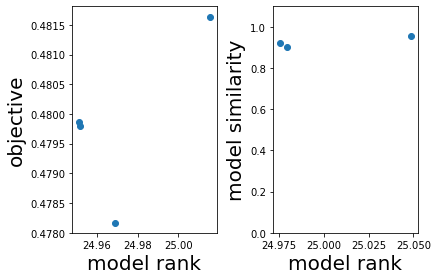

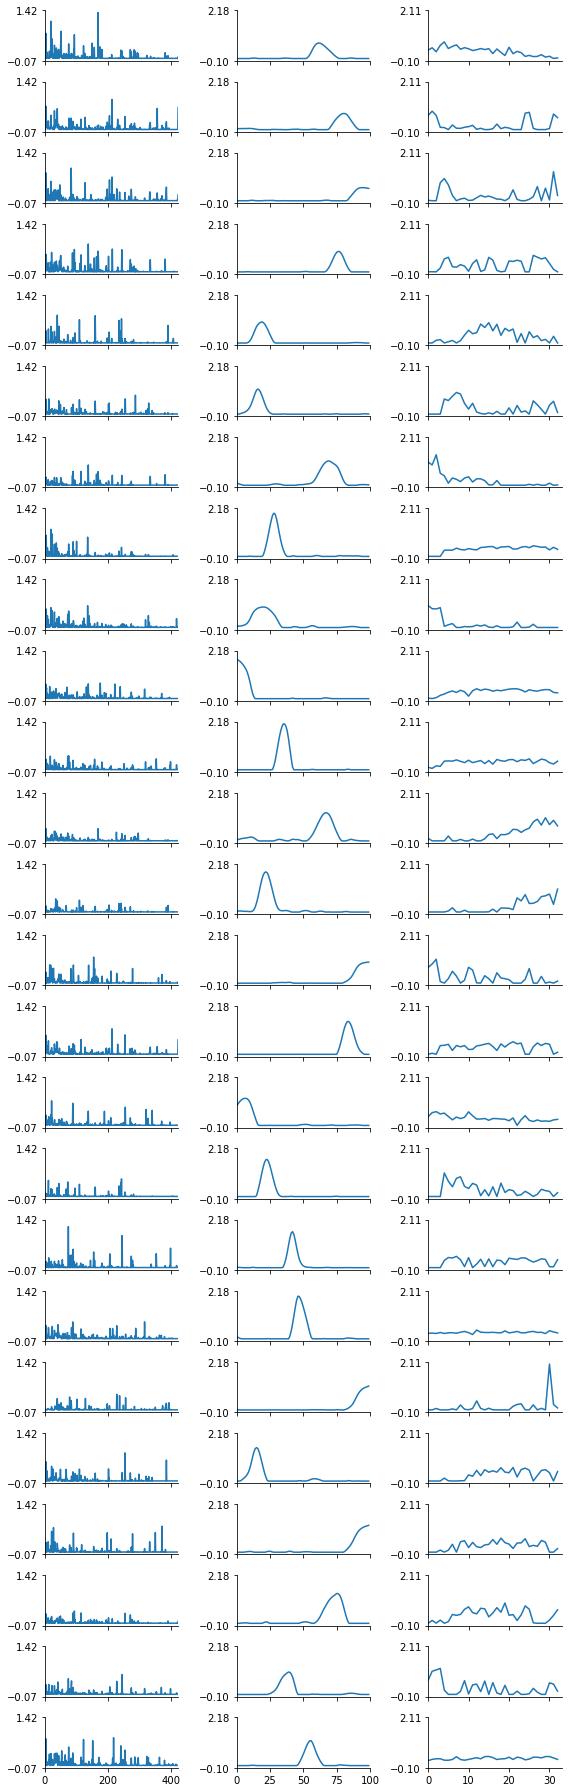

In [63]:
data = fr_map_trial_d[0,0] # ... specify a numpy array holding the tensor you wish to fit
data = data / np.maximum(data.max() * 0.5,data.max(axis=(1,2),keepdims=True))
# Fit an ensemble of models, 4 random replicates / optimization runs per model rank
ensemble = tt.Ensemble(fit_method="ncp_hals")
r_low=25
r_high = 26
ensemble.fit(data, ranks=range(r_low, r_high), replicates=4)

fig, axes = plt.subplots(1, 2)
tt.plot_objective(ensemble, ax=axes[0])   # plot reconstruction error as a function of num components.
tt.plot_similarity(ensemble, ax=axes[1])  # plot model similarity as a function of num components.
fig.tight_layout()

# Plot the low-d factors for an example model, e.g. rank-2, first optimization run / replicate.
num_components = r_high-1
replicate = 0
tt.plot_factors(ensemble.factors(num_components)[replicate])  # plot the low-d factors

plt.show()

In [35]:
def sort_tensor_factors(W,P,H):
    p_inds,Pt = na.sort_by_peak_within_factor(P.T)
    P = Pt.T
    W = W[:,p_inds]
    H = H[:,p_inds]
    W_inds,W_sorted,factor_assignment=na.sort_factors(W)
    W = W_sorted
    return W,P,H,W_inds
    
    

In [64]:
factors = ensemble.factors(num_components)[replicate]
W,P,H = factors.factors
W,P,H,W_inds=sort_tensor_factors(W,P,H)

factors.factors = [W,P,H]

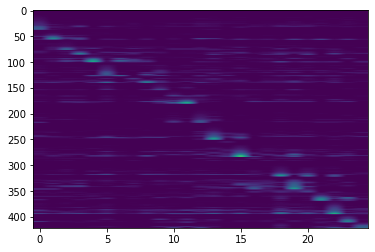

In [69]:
plt.imshow(W,aspect='auto')


In [70]:
data

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00737857],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.0085483 ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.00982432],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0. 

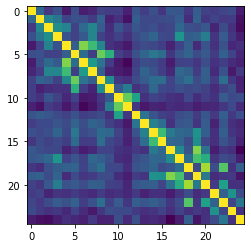

In [98]:
w_corr = np.corrcoef(W.T)
plt.imshow(w_corr)

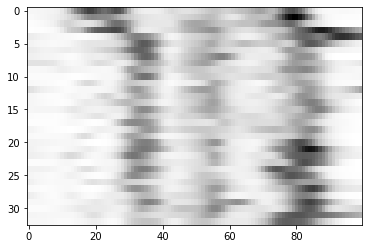

In [108]:
ma = scipy.stats.zscore(W[:,12])>2
pos_trial_subneuron = data[ma].mean(axis=0)
plt.imshow(pos_trial_subneuron.T,aspect='auto',cmap='Greys')

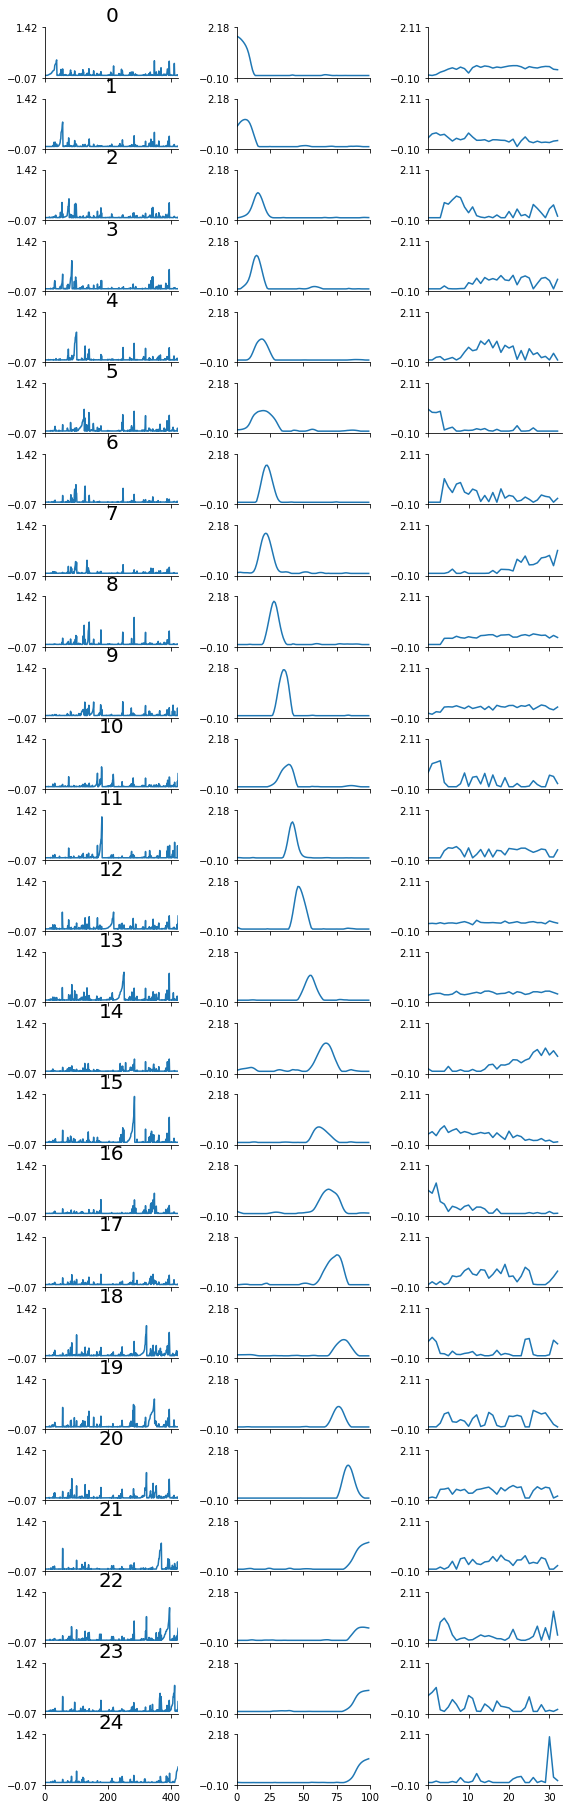

In [107]:
fig,axs,_=tt.plot_factors(factors)
for ii,ax in enumerate(axs):
    ax[0].set_title(ii)

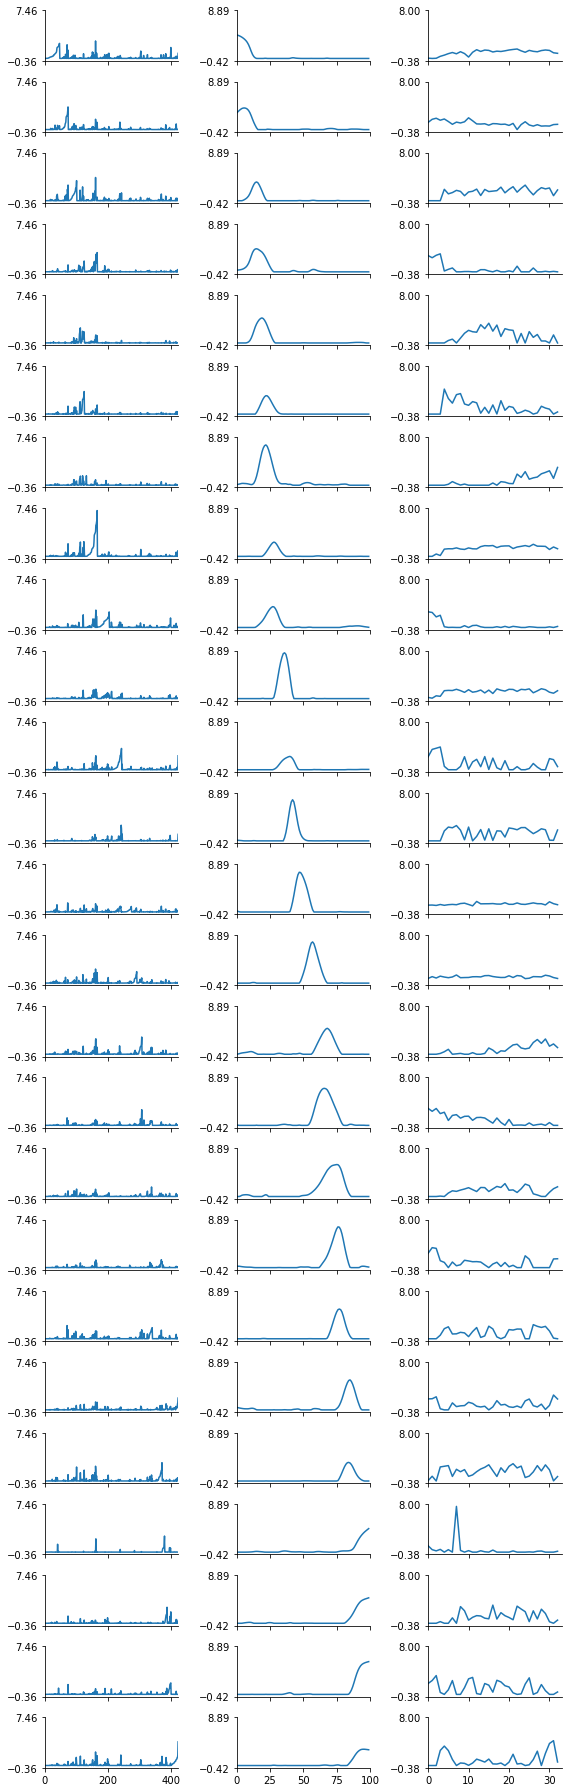

In [48]:
_=tt.plot_factors(factors)

(100, 12)

In [17]:
scipy.__version__

'1.10.1'